# Prototype for proper data handling

In [1]:
import os
from skimage import io, transform
from PIL import Image

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [74]:
df = pd.read_csv('info/all_data_info.csv')
df.head()

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,train_only,True,102257.jpg
1,Barnett Newman,1950.0,abstract,14559.0,6866.0,8867532.0,wikiart,Color Field Painting,Vir Heroicus Sublimis,train_only,True,75232.jpg
2,kiri nichol,2013.0,NaN,9003.0,9004.0,1756681.0,NaN,Neoplasticism,NaN,test_only,False,32145.jpg
3,kiri nichol,2013.0,NaN,9003.0,9004.0,1942046.0,NaN,Neoplasticism,NaN,test_only,False,20304.jpg
4,kiri nichol,2013.0,NaN,9003.0,9004.0,1526212.0,NaN,Neoplasticism,NaN,test_only,False,836.jpg


In [75]:
df = df.drop(['artist', 'pixelsx', 'pixelsy', 'size_bytes', 'source', 'title', 'artist_group', 'in_train', 'date'], axis=1)
df.dropna(inplace=True)
df.new_filename.name = 'filename'
df.columns = ['genre', 'style', 'filename']
df.head()

,genre,style,filename
0,abstract,Color Field Painting,102257.jpg
1,abstract,Color Field Painting,75232.jpg
5,mythological painting,Yamato-e,29855.jpg
6,abstract,Color Field Painting,62252.jpg
7,bird-and-flower painting,Ukiyo-e,49823.jpg


In [71]:
style = df.groupby('style').count()['filename']
genre = df.groupby('genre').count()['filename']

def lookup(df, s, col):
    return s.loc[df[col]]

df['style_count'] = df.apply(lookup, axis=1, args=(style, 'style'))
df['genre_count'] = df.apply(lookup, axis=1, args=(genre, 'genre'))
df

In [76]:
df.reset_index(drop=True, inplace=True)
df.to_csv('info/dataset_info.csv')

In [24]:
MIN_SAMPLES=3000
mask_genre = df['genre'].isin((df.groupby('genre').count()['filename'] >= MIN_SAMPLES).index)
mask_style = df['style'].isin((df.groupby('style').count()['filename'] >= MIN_SAMPLES).index)
newdf = df[mask_genre & mask_style]
newdf = newdf.reset_index(drop=True)
newdf.head()

,genre,style,filename
0,abstract,Color Field Painting,102257.jpg
1,abstract,Color Field Painting,75232.jpg
2,mythological painting,Yamato-e,29855.jpg
3,abstract,Color Field Painting,62252.jpg
4,bird-and-flower painting,Ukiyo-e,49823.jpg


In [4]:
print(len(df))
df = df.dropna()
print(len(df))

103250
101514


In [5]:
artist_s = df.groupby('artist').count().genre
artist_s.name = 'artist_count'
artist_df=  pd.DataFrame(artist_s)
artist_df.head()

,artist_count
artist,
Architect's visual,1
Capitain,1
François Leclerc du Tremblay,1
François Leclerc du Tremblay (detail),1
Fyodor Solntsev,37


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9521a0b390>]],
      dtype=object)

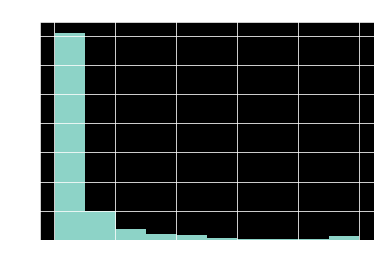

In [6]:
artist_df.hist()

In [7]:
genre_s = df.groupby('genre').count().artist
genre_s.name = 'genre_count'
genre_df = pd.DataFrame(genre_s)
genre_df.head()

,genre_count
genre,
abstract,9465
advertisement,82
allegorical painting,1033
animal painting,1552
battle painting,358


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f95219593c8>]],
      dtype=object)

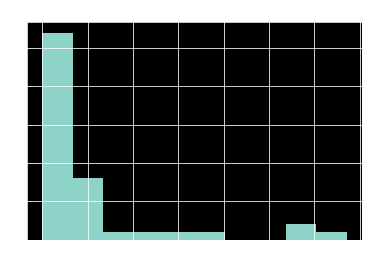

In [8]:
genre_df.hist()

In [9]:
style_s = df.groupby('style').count().artist
style_s.name = 'style_count'
style_df = pd.DataFrame(style_s)
style_df.head()

,style_count
style,
Abstract Art,973
Abstract Expressionism,2044
Academicism,971
Action painting,98
American Realism,277


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f95218ded68>]],
      dtype=object)

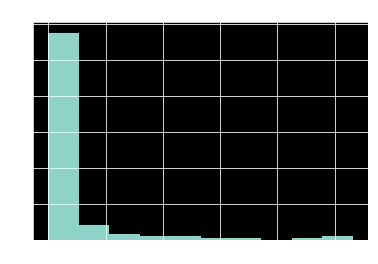

In [10]:
style_df.hist()

Not enough samples per class if we try to classify by painter -> genre and style.

In [11]:
df = df.drop('artist', axis=1)

In [12]:
genre_df.sort_values('genre_count', ascending=False)

,genre_count
genre,
portrait,16767
landscape,14959
genre painting,14217
abstract,9465
religious painting,7368
cityscape,5340
sketch and study,3626
illustration,3192
still life,3110


In [13]:
style_df.sort_values('style_count', ascending=False)

,style_count
style,
Impressionism,10638
Realism,10511
Romanticism,9244
Expressionism,6981
Post-Impressionism,5753
Art Nouveau (Modern),4887
Baroque,4394
Surrealism,4097
Symbolism,3471


In [16]:
MIN_SAMPLES = 3000
style_df[style_df.style_count >= MIN_SAMPLES]

,style_count
style,
Art Nouveau (Modern),4887
Baroque,4394
Expressionism,6981
Impressionism,10638
Post-Impressionism,5753
Realism,10511
Romanticism,9244
Surrealism,4097
Symbolism,3471


In [17]:
genre_df[genre_df.genre_count >= MIN_SAMPLES]

,genre_count
genre,
abstract,9465
cityscape,5340
genre painting,14217
illustration,3192
landscape,14959
portrait,16767
religious painting,7368
sketch and study,3626
still life,3110


In [78]:
common_df = df[(df['genre'].isin(genre_df[genre_df.genre_count >= MIN_SAMPLES].index)) & (df['style'].isin(style_df[style_df.style_count >= MIN_SAMPLES].index))]
len(common_df)

45876

In [74]:
pd.unique(common_df.genre)

array(['cityscape', 'landscape', 'genre painting', 'religious painting',
       'still life', 'illustration', 'portrait', 'sketch and study',
       'abstract'], dtype=object)

Remove abstract, perhaps sketch and study. Merge portraits and self-portraits. Look at the rest to decide what to merge or remove. Train a classifier on this to see accuracy, look at confusion matrix and:
- look at confusion matrix, merge what seems to be similar (also based on domain knowledge)
- remove what the classifier is still bad at classifying.

In [49]:
a = pd.unique(common_df['style'])
a.sort()
a

array(['Art Nouveau (Modern)', 'Baroque', 'Expressionism',
       'Impressionism', 'Post-Impressionism', 'Realism', 'Romanticism',
       'Surrealism', 'Symbolism'], dtype=object)

In [80]:
def lookup(df, other_df, col):
    return other_df.loc[df[col]]

common_df['style_count'] = common_df.apply(lookup, axis=1, args=(style_df, 'style'))
common_df['genre_count'] = common_df.apply(lookup, axis=1, args=(genre_df, 'genre'))
common_df.head()

/home/francois/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/francois/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,genre,style,new_filename,style_count,genre_count
9,cityscape,Romanticism,84512.jpg,9244,5340
11,landscape,Surrealism,70944.jpg,4097,14959
24,genre painting,Realism,28908.jpg,10511,14217
27,genre painting,Symbolism,24465.jpg,3471,14217
28,religious painting,Romanticism,7486.jpg,9244,7368


In [81]:
common_df.new_filename.name = 'filename'
common_df.columns = ['genre', 'style', 'filename', 'style_count', 'genre_count']
common_df.head()

,genre,style,filename,style_count,genre_count
9,cityscape,Romanticism,84512.jpg,9244,5340
11,landscape,Surrealism,70944.jpg,4097,14959
24,genre painting,Realism,28908.jpg,10511,14217
27,genre painting,Symbolism,24465.jpg,3471,14217
28,religious painting,Romanticism,7486.jpg,9244,7368


Save this in csv file when sure it's what is needed.

In [84]:
common_df = common_df.reset_index(drop=True)
common_df.head()

,genre,style,filename,style_count,genre_count
0,cityscape,Romanticism,84512.jpg,9244,5340
1,landscape,Surrealism,70944.jpg,4097,14959
2,genre painting,Realism,28908.jpg,10511,14217
3,genre painting,Symbolism,24465.jpg,3471,14217
4,religious painting,Romanticism,7486.jpg,9244,7368


In [100]:
common_df.to_csv('info/dataset_info.csv')

In [120]:
class PaintingsDataset(Dataset):
    """Dataset class to handle both genre and style label"""
    def __init__(self, csv_file, root_dir, min_samples_class=1000, transform=None):

        self.root_dir = root_dir
        self.transform = transform

        self.data = pd.read_csv(csv_file, index_col=0)
        self.min_samples_class = min_samples_class
        self.get_dataframe()
        
        self.genres = pd.unique(self.data['genre'])
        self.genres.sort()
        self.genre_to_idx = {self.genres[i]: i for i in range(len(self.genres))}
        self.samples_per_genre = [(self.data['genre']==g).sum() for g in self.genres]
        
        self.styles = pd.unique(self.data['style'])
        self.styles.sort()
        self.style_to_idx = {self.styles[i]: i for i in range(len(self.styles))}
        self.samples_per_style = [(self.data['style']==s).sum() for s in self.styles]
        
        self.genre_to_folder = {
            'portrait': 'portraits',
            'landscape': 'landscapes',
            'cityscape': 'cityscapes',
            'genre painting': 'genre_paintings',
            'religious painting': 'religious_paintings'
        }
        
        print(self.data.head())

    def get_dataframe(self):

        available_files = []
        for t in os.walk(self.root_dir):
            available_files += t[2]

        self.data = self.data[self.data.filename.isin(available_files)]
        
        genre = self.data.groupby('genre').count()['filename']
        style = self.data.groupby('style').count()['filename']

        def lookup(df, s, col):
            return s.loc[df[col]]

        self.data['genre_count'] = self.data.apply(lookup, axis=1, args=(genre, 'genre'))
        self.data['style_count'] = self.data.apply(lookup, axis=1, args=(style, 'style'))
        
        self.data = self.data[(self.data.genre_count >= self.min_samples_class) & (self.data.style_count >= self.min_samples_class)]
        self.data.reset_index(drop=True, inplace=True)
     
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        
        genre = self.data.loc[idx, 'genre']
        img_name = os.path.join(self.root_dir, self.genre_to_folder[genre], self.data.loc[idx, 'filename'])
        genre = self.genre_to_idx[genre]
        
        style = self.data.loc[idx, 'style']
        style = self.style_to_idx[style]
        
        with open(img_name, 'rb') as f:
            image = Image.open(f)
            image = image.convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, genre, style

In [55]:
df = pd.read_csv('info/dataset_info.csv', index_col=0)
df

,genre,style,filename
0,abstract,Color Field Painting,102257.jpg
1,abstract,Color Field Painting,75232.jpg
2,mythological painting,Yamato-e,29855.jpg
3,abstract,Color Field Painting,62252.jpg
4,bird-and-flower painting,Ukiyo-e,49823.jpg
5,abstract,Color Field Painting,63861.jpg
6,cityscape,Romanticism,84512.jpg
7,bird-and-flower painting,Ukiyo-e,53180.jpg
8,landscape,Surrealism,70944.jpg
9,religious painting,Northern Renaissance,59792.jpg


In [121]:
transform = transforms.Compose(
[
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])
dataset = PaintingsDataset('info/dataset_info.csv', 'paintings64/', transform=transform)
len(dataset)

                genre                 style   filename  genre_count  \
0  religious painting  Northern Renaissance  59792.jpg         5659   
1  religious painting  Northern Renaissance  82352.jpg         5659   
2  religious painting  Northern Renaissance  16876.jpg         5659   
3      genre painting               Realism  28908.jpg        10943   
4  religious painting           Romanticism   7486.jpg         5659   

   style_count  
0         1412  
1         1412  
2         1412  
3         5830  
4         4655  


32033

In [122]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=20, shuffle=True, num_workers=2)

In [124]:
it = iter(dataloader)
img, g, s = it.next()

In [125]:
img.shape

torch.Size([20, 3, 64, 64])

In [127]:
double(dataset.samples_per_genre

TypeError: float() argument must be a string or a number, not 'list'

In [85]:
len(dataset.styles)

10

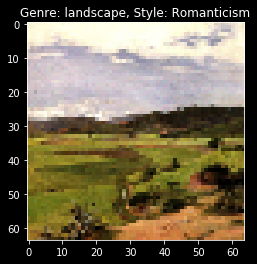

In [25]:
s, genre, style = dataset.__getitem__(13989)

plt.imshow(s)
plt.title('Genre: {}, Style: {}'.format(dataset.genres[genre], dataset.styles[style]))
plt.show()

In [103]:
fixed_z.squeeze()


-1.6735  0.5797  1.5393  ...   0.0000  0.0000  0.0000
 0.6020 -1.7215  0.7076  ...   0.0000  0.0000  0.0000
-1.5435  0.3494 -1.9234  ...   0.0000  0.0000  0.0000
          ...             ⋱             ...          
-2.0467  0.7099  0.0629  ...   0.0000  0.0000  1.0000
-0.7920  0.7748  0.4993  ...   0.0000  0.0000  1.0000
 0.9528  1.8732 -0.0881  ...   0.0000  0.0000  1.0000
[torch.FloatTensor of size 150x115]

In [97]:
fixed_genre_constant_style.squeeze()



Columns 0 to 12 
    1     0     0     0     0     0     0     0     1     0     0     0     0
    1     0     0     0     0     0     0     0     1     0     0     0     0
    1     0     0     0     0     0     0     0     1     0     0     0     0
    1     0     0     0     0     0     0     0     1     0     0     0     0
    1     0     0     0     0     0     0     0     1     0     0     0     0
    1     0     0     0     0     0     0     0     1     0     0     0     0
    1     0     0     0     0     0     0     0     1     0     0     0     0
    1     0     0     0     0     0     0     0     1     0     0     0     0
    1     0     0     0     0     0     0     0     1     0     0     0     0
    1     0     0     0     0     0     0     0     1     0     0     0     0
    0     1     0     0     0     0     0     0     1     0     0     0     0
    0     1     0     0     0     0     0     0     1     0     0     0     0
    0     1     0     0     0     0     0    

In [94]:
fixed_genre.squeeze()


    1     0     0     0     0
    1     0     0     0     0
    1     0     0     0     0
    1     0     0     0     0
    1     0     0     0     0
    1     0     0     0     0
    1     0     0     0     0
    1     0     0     0     0
    1     0     0     0     0
    1     0     0     0     0
    0     1     0     0     0
    0     1     0     0     0
    0     1     0     0     0
    0     1     0     0     0
    0     1     0     0     0
    0     1     0     0     0
    0     1     0     0     0
    0     1     0     0     0
    0     1     0     0     0
    0     1     0     0     0
    0     0     1     0     0
    0     0     1     0     0
    0     0     1     0     0
    0     0     1     0     0
    0     0     1     0     0
    0     0     1     0     0
    0     0     1     0     0
    0     0     1     0     0
    0     0     1     0     0
    0     0     1     0     0
    0     0     0     1     0
    0     0     0     1     0
    0     0     0     1     0
    0    